<a href="https://colab.research.google.com/github/kwanderer/MachineLearning/blob/main/MD_LSTM_step_20_lr_0_001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



#Datu kopa

Datu kopas avots: https://www.kaggle.com/uysalserkan/fault-induction-motor-dataset

Darbā tiek izmantota indukcijas motora parametru datu bāze. Izmantotajā datu kopā ir dati, kas tika iegūti SpectraQuest aparatūras kļūdu simulatorā (Machinery Fault Simulator).

Katra mērījumu secība tika ģenerēta ar frekvenci 50 kHz 5 sekunžu laikā, kopā 250 000 mērījumi.

Dati ir apkopoti vairākos failos, dažādos darbības stāvokļos un to apjoms ir ļoti liels. Šajā darbā tika izmantota daļa(viena mērījumu secība) no motora normālas darbības datiem.


Dati ir apkopoti tabulā, kura satur 8 parametrus. Dati ir iedalīti sekojošās kolonas:

**tachometer** – tahometra signāls, kas ļauj novērtēt rotācijas frekvenci

**und-accelerometer-axial** - apakšā esošā gultņa akselerometrs (aksiālais virziens)

**und-accelerometer-radial** – apakšā esošā gultņa akselerometrs (radiālais virziens)

**und-accelerometer-tangential** - apakšā esošā gultņa akselerometrs (tangenciālais virziens)

**over-accelerometer-axial** - pārkares gultņa akselerometrs (aksiālais virziens)

**over-accelerometer-radial** – pārkares gultņa akselerometrs (radiālais  virziens)

**over-accelerometer-tangential**  - pārkares gultņa akselerometrs (tangenciālais virziens)

**microphone** – mikrofona vērtība


#Datu ielasīšana un satura vizualizācija

In [47]:
import keras
from keras.layers import LSTM, Dropout, Dense
import tensorflow as tf
import numpy as np
import pandas as pd

from sklearn import linear_model  #pip install sklearn - loti plasa masinapmacibas biblioteka
from sklearn.linear_model import LinearRegression  
import csv          #pip install csv - darbam ar CSV datu kopam
import requests     #pip install requests  - vienkarsakam darbam ar tiessaistes CSV datu kopam tiessaistes

import matplotlib
import matplotlib.pyplot as plt

import glob


In [48]:
from google.colab import drive
import os
drive.mount('/content/gdrive')
os.chdir("/content/gdrive/MyDrive/Colab Notebooks/data/motor/")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [49]:
#extension = 'csv'
#all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

In [50]:
#combine all files in the list
#combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
#export to csv
#combined_csv.to_csv( "combined_csv.csv", index=False, encoding='utf-8-sig')

In [51]:
data = pd.read_csv("combined_csv.csv")

In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 9 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   tachometer                     500000 non-null  float64
 1   und-accelerometer-axial        500000 non-null  float64
 2   und-accelerometer-radial       500000 non-null  float64
 3   und-accelerometer-tangential   500000 non-null  float64
 4   over-accelerometer-axial       500000 non-null  float64
 5   over-accelerometer-radial      500000 non-null  float64
 6   over-accelerometer-tangential  500000 non-null  float64
 7   microphone                     500000 non-null  float64
 8   Class                          500000 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 34.3 MB


In [53]:
rec_count = len(data)
rec_count

500000

# Datu dalīšana mazākos gabalos

In [54]:
sequence_length = 200

In [55]:
def generate_data(X, y, sequence_length = 200, step = 20):
    X_local = []
    y_local = []
    for start in range(0, len(data) - sequence_length, step):
        end = start + sequence_length
        X_local.append(X[start:end])
        y_local.append(y[end-1])
    return np.array(X_local), np.array(y_local)

X_sequence, y = generate_data(data.loc[:, "tachometer":"microphone"].values, data.Class)

In [56]:
X_sequence.shape, y.shape

((24990, 200, 8), (24990,))

# Random/Shuffle

In [57]:
shuffler = np.random.permutation(len(X_sequence))
X_sequence_shuffled = X_sequence[shuffler]
y_shuffled = y[shuffler]

# LSTM

In [58]:
from tensorflow.keras import optimizers
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model = keras.Sequential()
model.add(LSTM(100, input_shape = (200, 8)))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))

#model.compile(loss='mean_squared_error', optimizer=sgd)
model.compile(loss="binary_crossentropy"
              , metrics=[keras.metrics.binary_accuracy]
              , optimizer=sgd)

model.summary()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100)               43600     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 43,701
Trainable params: 43,701
Non-trainable params: 0
_________________________________________________________________


In [59]:
training_size = int(len(X_sequence) * 0.7)

In [60]:
X_train, y_train = X_sequence_shuffled[:training_size], y_shuffled[:training_size]
X_test, y_test = X_sequence_shuffled[training_size:], y_shuffled[training_size:]

In [61]:
history = model.fit(X_train, y_train, batch_size=64, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
274/274 [==============================] - 63s 222ms/step - loss: 0.5870 - binary_accuracy: 0.7304 - val_loss: 0.4514 - val_binary_accuracy: 0.8801
Epoch 2/50
274/274 [==============================] - 61s 223ms/step - loss: 0.3551 - binary_accuracy: 0.8861 - val_loss: 0.2782 - val_binary_accuracy: 0.9036
Epoch 3/50
274/274 [==============================] - 63s 230ms/step - loss: 0.2434 - binary_accuracy: 0.9208 - val_loss: 0.2149 - val_binary_accuracy: 0.9324
Epoch 4/50
274/274 [==============================] - 63s 229ms/step - loss: 0.4720 - binary_accuracy: 0.8207 - val_loss: 0.2945 - val_binary_accuracy: 0.9006
Epoch 5/50
274/274 [==============================] - 62s 227ms/step - loss: 0.2800 - binary_accuracy: 0.8993 - val_loss: 0.2423 - val_binary_accuracy: 0.9086
Epoch 6/50
274/274 [==============================] - 66s 240ms/step - loss: 0.2188 - binary_accuracy: 0.9211 - val_loss: 0.1615 - val_binary_accuracy: 0.9470
Epoch 7/50
274/274 [==========================

In [62]:
model.evaluate(X_test, y_test)

235/235 [==============================] - 10s 43ms/step - loss: 0.1472 - binary_accuracy: 0.9546


[0.1472177505493164, 0.9546485543251038]

In [63]:
y_test_prob = model.predict(X_test, verbose=1)

235/235 [==============================] - 11s 43ms/step


In [64]:
y_test_pred = np.where(y_test_prob > 0.5, 1, 0)

In [65]:
from sklearn.metrics import confusion_matrix

In [66]:
confusion_matrix(y_test, y_test_pred)

array([[3690,   54],
       [ 286, 3467]])

Confusion matrix, without normalization
[[3690   54]
 [ 286 3467]]
Normalized confusion matrix
[[0.99 0.01]
 [0.08 0.92]]


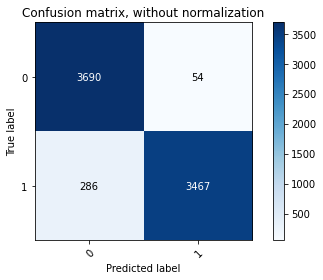

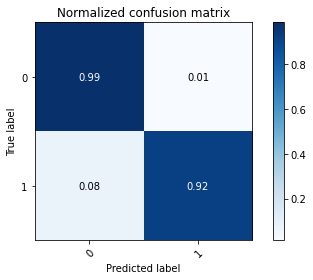

In [67]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

class_names = np.array(['0', '1'])

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_test_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_test_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [68]:
def plot_learningCurve(history, epoch):
  # Plot training & validation accuracy values
  epoch_range = range(1, epoch+1)
  plt.plot(epoch_range, history.history['binary_accuracy'])
  plt.plot(epoch_range, history.history['val_binary_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

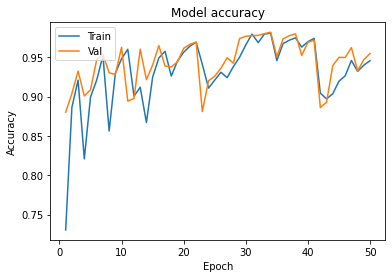

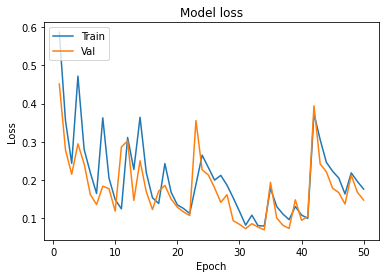

In [69]:
plot_learningCurve(history, 50)